# Variable Selection Procedure

### Import packages and load file

In [9]:
import pandas as pd
from pandas import read_excel
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

pd.set_option('Display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [7]:
import asgl 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn_timeseries import TimeSeriesRandomForestRegressor
from sklearn_timeseries import optimal_block_length
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = read_excel("./data_womacro_test.xlsx", index_col = 0)
df_raw = df_raw.rename(columns=lambda x: x[1:] if x.startswith('^') else x)

""" Below this is all robustness check arguments """
# df_raw = read_excel("./data_update_0515.xlsx", index_col = 0)
# df_raw = df_raw.rename(columns=lambda x: x[1:] if x.startswith('^') else x)

# df_raw = df_raw.loc[:,~(df_raw.columns.str.contains("google"))]
# google_df = pd.read_csv("../google_trend_update_short_0516.csv")
# google_df['date'] = pd.to_datetime(google_df['date'].astype("string")).dt.to_period('d')
# google_df = google_df.set_index('date').to_timestamp()
# google_df.columns = ['google_1', 'google_2', 'google_3', 'google_4', 'google_5', 'google_6']
# df_raw = pd.concat([df_raw, google_df.loc[google_df.index.isin(df_raw.index)]], axis=1)

# epu = pd.read_csv("../epu_news.csv")
# epu['date'] = pd.to_datetime(epu['date'].astype("string")).dt.to_period('d')
# epu = epu.set_index('date').to_timestamp()
# df_raw = pd.concat([df_raw, epu.loc[epu.index.isin(df_raw.index)]], axis=1)

# df_raw = df_raw.iloc[1459:2461,:] # 2016-01-04 ~ 2020-01-31

df_raw = df_raw.loc[(df_raw.index > '2010-01-01') & (df_raw.index < '2018-12-31')]
# df_raw = df_raw.loc[(df_raw.index > '2018-12-31') & (df_raw.index < '2022-12-31')]

### ★ Variables Selection

In [3]:
df_raw.shape # 2197 , 44 

(2197, 44)

In [4]:
sent_list = ['Score','google_1','google_2','google_3','google_4','google_5','google_6']

In [5]:
Y = df_raw
Y = Y.iloc[0:Y.shape[0]-120,:]
indice = 0
lag = 22
method = 'SENT'
selection = 'GL'

In [10]:
y_scaler = MinMaxScaler()
scaled = y_scaler.fit_transform(Y.iloc[:,indice].values.reshape(-1,1)) # For inverse transformation    
scaled = pd.DataFrame(MinMaxScaler().fit_transform(Y.values), columns = Y.columns)
# pca = PCA(n_components=4).fit_transform(scaled)
# pca_df = pd.DataFrame(data = pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
# Y2 = pd.concat([scaled, pca_df], axis=1)
Y2 = scaled


list_of_df = [] # making list of df

""" ORIGINAL CODE FOR COLUMNS """    
# for j in range(lag+3) : # 0 1 2 3 4
#     df_temp = Y2_temp2.shift(j)
#     list_of_df.append(df_temp)       
        
# aux_temp = pd.concat(list_of_df, axis=1).dropna()

""" NEW CODE FOR ARRANGING COLUMN NAMES """
for j, names in enumerate(range(lag+4)) :
    df_temp = Y2.shift(j)
    df_temp.columns = [col_name+'_lag{}'.format(j) for col_name in df_temp.columns] # warning (feature name must match)
    list_of_df.append(df_temp)  
    
aux = pd.concat(list_of_df, axis=1).dropna()
    # aux = aux.loc[:,~((aux.columns.str.contains("VIX")) & ~(aux.columns.str.contains("lag0")))]
    # aux = aux.loc[:,((aux.columns.isin(["VIX_D_X_lag0", 'VIX_W_X_lag0',"VIX_M_X_lag0"])) | ~(aux.columns.str.contains("VIX")))] # drop all VIX which are lagged
    
y = aux.iloc[:,indice]
X = aux.iloc[:,Y2.shape[1]*lag:]

if lag == 1 :
   X_out = aux.tail(1).iloc[:,0:X.shape[1]]
   k = 1
    
else :
    X_out = aux.iloc[:,Y2.shape[1]*(lag-1):]
    X_out = X_out.tail(1).iloc[:,0:X.shape[1]]

X = X.loc[:,(~(X.columns.str.contains('VIX')) | (X.columns.isin(X.loc[:,X.columns.str.contains('VIX')].iloc[:,0:3].columns)))] # Only VIX with first 3
X_out = X_out.loc[:,(~(X_out.columns.str.contains('VIX')) | (X_out.columns.isin(X_out.loc[:,X_out.columns.str.contains('VIX')].iloc[:,0:3].columns)))] # Only VIX with first 3

if lag == 5 : k = 1
if (lag == 10) or (lag ==22) : k = 2

""" METHOD : HAR / ECO / SENT """

if method == 'HAR':
    X = X.loc[:, X.columns.str.contains("VIX")]
    X_out = X_out.loc[:, X_out.columns.str.contains("VIX")]

if method == 'ECO':
    X = X.loc[:, ~(X.columns.str.contains("dis") | X.columns.str.contains("Score") | X.columns.str.contains("google_1") | 
          X.columns.str.contains("google_2") | X.columns.str.contains("google_3")  | X.columns.str.contains("google_4") | 
          X.columns.str.contains("google_5") | X.columns.str.contains("google_6")  | X.columns.str.contains("policy"))]
    
    X_out = X_out.loc[:, ~(X_out.columns.str.contains("dis") | X_out.columns.str.contains("Score") | X_out.columns.str.contains("google_1") | 
          X_out.columns.str.contains("google_2") | X_out.columns.str.contains("google_3") | X_out.columns.str.contains("google_4") | 
          X_out.columns.str.contains("google_5") | X_out.columns.str.contains("google_6") | X_out.columns.str.contains("policy"))]

if method =='SENT':
    pass


""" Variable Selection when ITERATION """

if selection == 'LASSO':
    lasso_X = X.loc[:,(~(X.columns.str.contains("VIX")))]
    kfcv = KFold(n_splits=5, shuffle=False)
    search_kfcv = GridSearchCV(Lasso(), {'alpha':np.arange(0.001,1,0.1)}, cv=kfcv, scoring='neg_mean_squared_error', verbose=0)
    search_kfcv.fit(lasso_X.values,y)
    best_param = search_kfcv.best_params_ # SAVE
    
    coefficients = search_kfcv.best_estimator_.coef_
    lasso_importances = pd.Series(np.abs(coefficients), index = lasso_X.columns)
    lasso_importances_top = lasso_importances.loc[lasso_importances != 0].sort_values(ascending=False)[0:12]
    
    # index = [x[:-5] for x in lasso_importances_top.index] # delete final lag
    
    fig = plt.figure(figsize=(8,6)) # SAVE
    sns.barplot(x=lasso_importances_top , y=lasso_importances_top.index)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f'Feature Importance Lasso : lag-{lag}')
    plt.close()
    
    X = X.loc[:,(X.columns.isin(lasso_importances_top.index)) | (X.columns.str.contains("VIX"))]
    X_out = X_out.loc[:,(X_out.columns.isin([s[:-k] + str(int(s[-k:])-1) for s in lasso_importances_top.index])) 
                      | (X_out.columns.str.contains("VIX"))]

    
if selection == 'ALASSO':
    
    
    lasso_X = X.loc[:,(~(X.columns.str.contains("VIX")))]
    
    """ Adaptive Lasso """
    # lambda_list =np.arange(0.001,0.1,0.1)
    # mdl_cv = asgl.CV(model='lm',penalization='alasso',lambda1 = lambda_list,weight_technique='unpenalized',random_state = 99, nfolds=5)
    # lambda1 = lambda_list[mdl_cv.cross_validation(X.to_numpy(), y.to_numpy()).mean(axis=1).argmin()]
    lambda1 = 0.001 # Optimal lambda for almost all (for computational time we set this to 0.001)
    weights = asgl.WEIGHTS(model='lm', penalization="alasso", weight_technique='unpenalized')
    lasso_weights,_ = weights.fit(lasso_X.to_numpy(), y.to_numpy())
    mdl_alasso = asgl.ASGL(model='lm', penalization='alasso', lambda1 = lambda1, lasso_weights=lasso_weights, parallel=True, intercept=False)
    mdl_alasso.fit(lasso_X.to_numpy(), y.to_numpy())
    
    coefficients = mdl_alasso.coef_
    lasso_importances = pd.Series(np.abs(coefficients[0]), index = lasso_X.columns)
    lasso_importances_top = lasso_importances.loc[lasso_importances != 0].sort_values(ascending=False)[0:12]

    
    fig = plt.figure(figsize=(8,6)) # SAVE
    sns.barplot(x=lasso_importances_top , y=lasso_importances_top.index)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f'Feature Importance ALasso : lag-{lag}')
    plt.close()
    
    X = X.loc[:,(X.columns.isin(lasso_importances_top.index)) | (X.columns.str.contains("VIX"))]
    X_out = X_out.loc[:,(X_out.columns.isin([s[:-k] + str(int(s[-k:])-1) for s in lasso_importances_top.index])) 
                      | (X_out.columns.str.contains("VIX"))]
    

if selection == 'RF_IID' :
    
    """ Random Forest with IID """
    lasso_X = X.loc[:,(~(X.columns.str.contains("VIX")))]
    
    # kfcv = KFold(n_splits=5, shuffle=False)
    # parameters = {'n_estimators': [100, 150],'max_depth': [4,6,8]}
    # grid_cv = GridSearchCV(TimeSeriesRandomForestRegressor(bootstrap='sb', random_state=42, n_jobs = -1), parameters, cv = kfcv, n_jobs= -1)
    # grid_cv.fit(lasso_X.values, y)
    
    # rf_run = TimeSeriesRandomForestRegressor(bootstrap='iid', random_state=42, max_depth=grid_cv.best_params_['max_depth'], n_estimators=grid_cv.best_params_['n_estimators']) # gridsearch best parametesr
    rf_run = TimeSeriesRandomForestRegressor(bootstrap='iid', random_state=42, max_depth=8, n_estimators=150)
    rf_run.fit(lasso_X.values, y)
    rf_importances_values = rf_run.feature_importances_
    lasso_importances = pd.Series(rf_importances_values, index = lasso_X.columns)
    lasso_importances_top = lasso_importances.sort_values(ascending=False)[0:12]
    
    fig = plt.figure(figsize=(8,6)) # SAVE
    sns.barplot(x=lasso_importances_top , y=lasso_importances_top.index)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f'Feature Importance ALasso : lag-{lag}')
    plt.close()

    X = X.loc[:,(X.columns.isin(lasso_importances_top.index)) | (X.columns.str.contains("VIX"))]
    X_out = X_out.loc[:,(X_out.columns.isin([s[:-k] + str(int(s[-k:])-1) for s in lasso_importances_top.index])) 
                      | (X_out.columns.str.contains("VIX"))]
    

# if selection == 'RF_SB' :
    
#     """ Random Forest with IID """
#     lasso_X = X.loc[:,(~(X.columns.str.contains("VIX")))]
    
#     # kfcv = KFold(n_splits=5, shuffle=False)
#     # parameters = {'n_estimators': [100, 150, 200],'max_depth': [4,6,8]}
#     # grid_cv = GridSearchCV(TimeSeriesRandomForestRegressor(bootstrap='sb', random_state=42, n_jobs = -1), parameters, cv = kfcv, n_jobs= -1)
#     # grid_cv.fit(lasso_X.values, y)
    
#     # rf_run = TimeSeriesRandomForestRegressor(bootstrap='sb', random_state=42, max_depth=grid_cv.best_params_['max_depth'], n_estimators=grid_cv.best_params_['n_estimators'])
#     rf_run = TimeSeriesRandomForestRegressor(bootstrap='sb', random_state=42, max_depth=6, n_estimators=100) # gridsearch best parametesr
#     rf_run.fit(lasso_X.values, y)
#     rf_importances_values = rf_run.feature_importances_
#     rf_importances = pd.Series(rf_importances_values, index = lasso_X.columns)
#     rf_importances_top = rf_importances.sort_values(ascending=False)[0:20]
    
#     fig = plt.figure(figsize=(8,6))
#     sns.barplot(x=rf_importances_top, y=rf_importances_top.index)
#     plt.xlabel("Importance")
#     plt.ylabel("Features")
#     plt.title(f'Feature Importance RF_SB: lag-{lag}')
#     plt.close()

#     X = X.loc[:,(X.columns.isin(rf_importances_top.index)) | (X.columns.str.contains("VIX"))]
#     X_out = X_out.loc[:,(X_out.columns.isin([s[:-1] + str(int(s[-1:])-1) for s in rf_importances_top.index])) 
#                       | (X_out.columns.str.contains("VIX"))]

if selection == 'GL' :
    
    "GROUP LASSO SELECTION"
    
    lasso_X = X.loc[:,(~(X.columns.str.contains("VIX")))]
    
    group_index = np.array([1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                            1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                            1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                            1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5
                        ]) 
    
    lambda1 = 0.001
    exp = asgl.ASGL(model='lm', penalization='gl', lambda1=lambda1, intercept=False)
    exp.fit(lasso_X.to_numpy(), y.to_numpy(), group_index=group_index)
    coefficients = exp.coef_
    lasso_importances = pd.Series(np.abs(coefficients[0]), index = lasso_X.columns)
    lasso_importances_top = lasso_importances.loc[lasso_importances != 0].sort_values(ascending=False)[0:12]
    
    fig = plt.figure(figsize=(8,6)) # SAVE
    sns.barplot(x=lasso_importances_top , y=lasso_importances_top.index)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f'Feature Importance Group Lasso : lag-{lag}')
    plt.close()
    
    X = X.loc[:,(X.columns.isin(lasso_importances_top.index)) | (X.columns.str.contains("VIX"))]
    X_out = X_out.loc[:,(X_out.columns.isin([s[:-k] + str(int(s[-k:])-1) for s in lasso_importances_top.index])) 
                      | (X_out.columns.str.contains("VIX"))]
    

if selection == 'ASGL' :
    
    "Adaptive Group Lasso Selection"
    
    lasso_X = X.loc[:,(~(X.columns.str.contains("VIX")))]
    
    group_index = np.array([1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                            1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                            1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                            1, 1, 1, 1, 1, 1, 1, 2, 5, 2, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5
                        ]) 
    

    weights = asgl.WEIGHTS(model='lm', penalization='asgl', weight_technique='unpenalized')
    lasso_weights,_ = weights.fit(lasso_X.to_numpy(), y.to_numpy(), group_index=group_index)
    gl_weights = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    exp = asgl.ASGL(model='lm', penalization='asgl', lambda1=lambda1, lasso_weights=lasso_weights, gl_weights=gl_weights, intercept=False, alpha=0.5, parallel=True)
    exp.fit(lasso_X.to_numpy(), y.to_numpy(), group_index=group_index)
    coefficients = exp.coef_
    lasso_importances = pd.Series(np.abs(coefficients[0]), index = lasso_X.columns)
    lasso_importances_top = lasso_importances.loc[lasso_importances != 0].sort_values(ascending=False)[0:12]
    
    fig = plt.figure(figsize=(8,6)) # SAVE
    sns.barplot(x=lasso_importances_top , y=lasso_importances_top.index)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f'Feature Importance ASGL : lag-{lag}')
    plt.close()

    X = X.loc[:,(X.columns.isin(lasso_importances_top.index)) | (X.columns.str.contains("VIX"))]
    X_out = X_out.loc[:,(X_out.columns.isin([s[:-k] + str(int(s[-k:])-1) for s in lasso_importances_top.index])) 
                      | (X_out.columns.str.contains("VIX"))]

#### ◎ For 2010-2018 Check all horizons

In [11]:
lasso_1 = pd.DataFrame(lasso_importances_top, columns = ['value'])

In [12]:
lasso_5 = pd.DataFrame(lasso_importances_top, columns = ['value'])

In [13]:
lasso_10 = pd.DataFrame(lasso_importances_top, columns = ['value'])

In [14]:
lasso_22 = pd.DataFrame(lasso_importances_top, columns = ['value'])

#### ◎ For 2019-2022 Check only horizon 1

In [15]:
lasso_1 = pd.DataFrame(lasso_importances_top, columns = ['value'])

In [16]:
alasso_1 = pd.DataFrame(lasso_importances_top, columns = ['value'])

In [17]:
asgl_1 =  pd.DataFrame(lasso_importances_top, columns = ['value'])

In [18]:
rf_1 =  pd.DataFrame(lasso_importances_top, columns = ['value'])

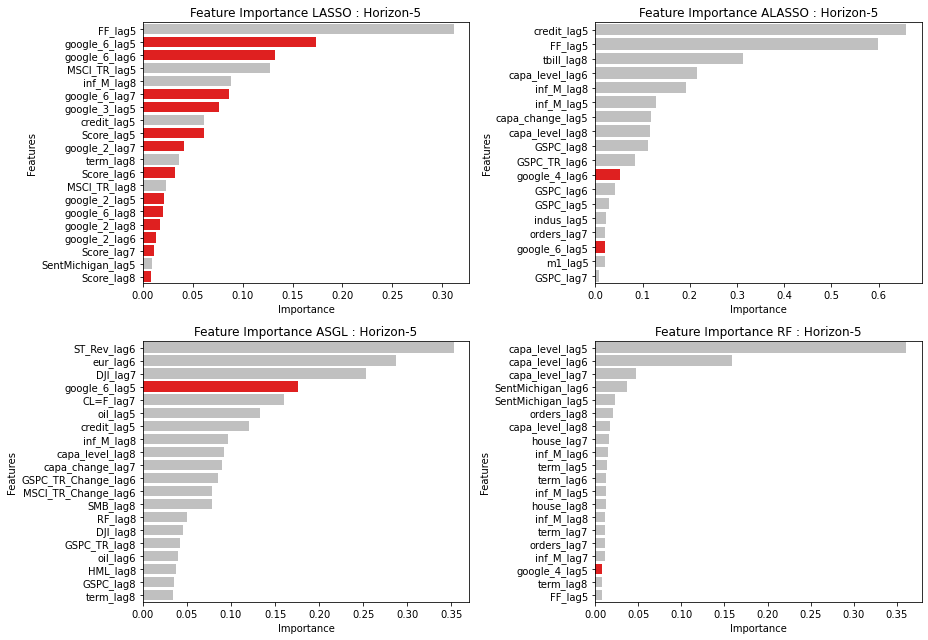

In [437]:
fig = plt.figure(figsize=(13,9))

plt.subplot(2,2,1)
# cols = ['grey' if (y.index.str.contains('|'.join(sent_list))) else 'red' for y in lasso_1.index]
sns.barplot(x=lasso_1.value.mask(lasso_1.index.str.contains('|'.join(sent_list))) , y=lasso_1.index, color = 'silver')
sns.barplot(x=lasso_1.value.mask(~(lasso_1.index.str.contains('|'.join(sent_list)))) , y=lasso_1.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance LASSO : Horizon-5')

plt.subplot(2,2,2)
sns.barplot(x=alasso_1.value.mask(alasso_1.index.str.contains('|'.join(sent_list))) , y=alasso_1.index, color = 'silver')
sns.barplot(x=alasso_1.value.mask(~(alasso_1.index.str.contains('|'.join(sent_list)))) , y=alasso_1.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance ALASSO : Horizon-5')

plt.subplot(2,2,3)
sns.barplot(x=asgl_1.value.mask(asgl_1.index.str.contains(' |'.join(sent_list))) , y=asgl_1.index, color = 'silver')
sns.barplot(x=asgl_1.value.mask(~(asgl_1.index.str.contains('|'.join(sent_list)))) , y=asgl_1.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance ASGL : Horizon-5')

plt.subplot(2,2,4)
sns.barplot(x=rf_1.value.mask(rf_1.index.str.contains('|'.join(sent_list))) , y=rf_1.index, color = 'silver')
sns.barplot(x=rf_1.value.mask(~(rf_1.index.str.contains('|'.join(sent_list)))) , y=rf_1.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance RF : Horizon-5')


fig.tight_layout() 

### ☆ Plot Variable Importance

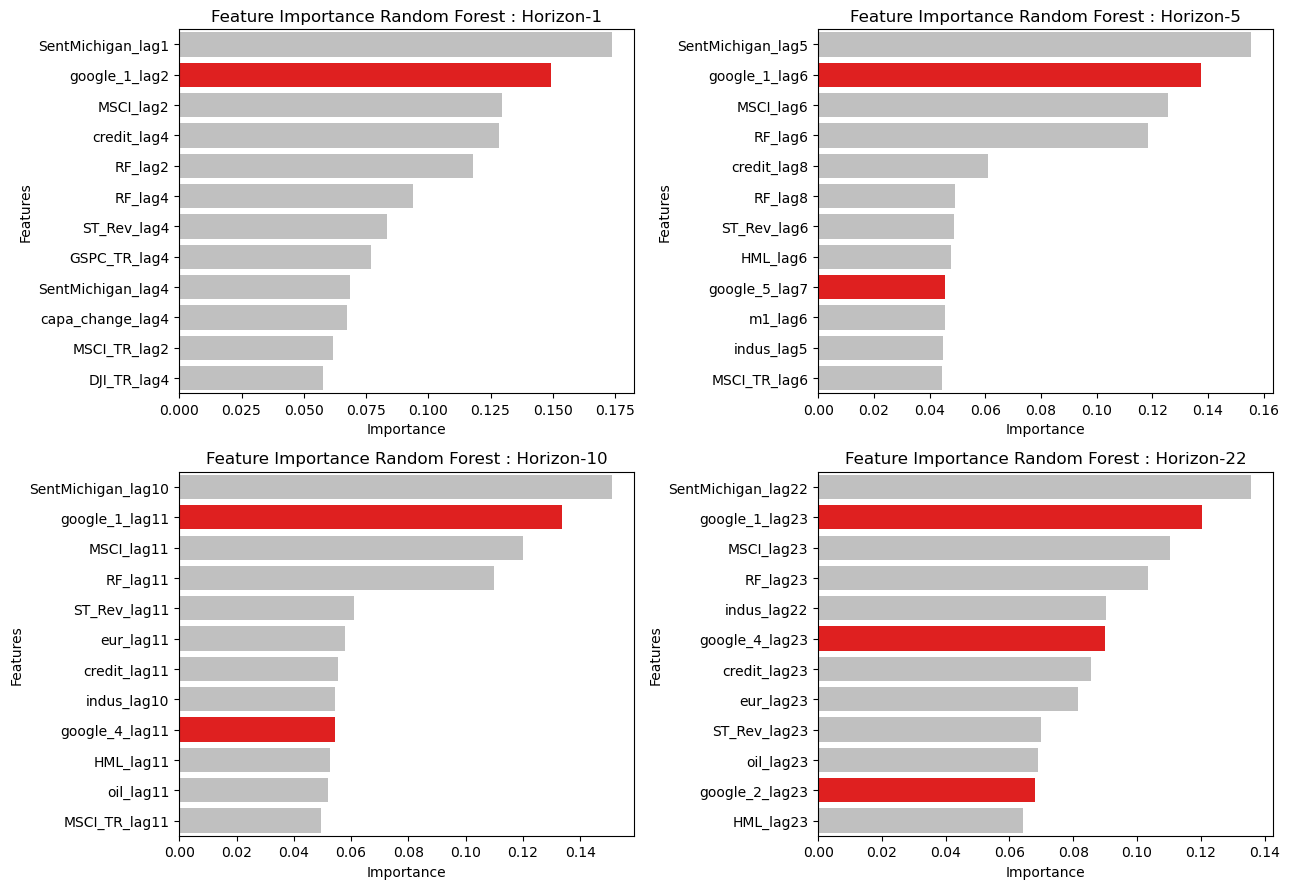

In [229]:
fig = plt.figure(figsize=(13,9))

plt.subplot(2,2,1)
# cols = ['grey' if (y.index.str.contains('|'.join(sent_list))) else 'red' for y in lasso_1.index]
sns.barplot(x=lasso_1.value.mask(lasso_1.index.str.contains('|'.join(sent_list))) , y=lasso_1.index, color = 'silver')
sns.barplot(x=lasso_1.value.mask(~(lasso_1.index.str.contains('|'.join(sent_list)))) , y=lasso_1.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance Random Forest : Horizon-1')

plt.subplot(2,2,2)
sns.barplot(x=lasso_5.value.mask(lasso_5.index.str.contains('|'.join(sent_list))) , y=lasso_5.index, color = 'silver')
sns.barplot(x=lasso_5.value.mask(~(lasso_5.index.str.contains('|'.join(sent_list)))) , y=lasso_5.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance Random Forest : Horizon-5')

plt.subplot(2,2,3)
sns.barplot(x=lasso_10.value.mask(lasso_10.index.str.contains(' |'.join(sent_list))) , y=lasso_10.index, color = 'silver')
sns.barplot(x=lasso_10.value.mask(~(lasso_10.index.str.contains('|'.join(sent_list)))) , y=lasso_10.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance Random Forest : Horizon-10')

plt.subplot(2,2,4)
sns.barplot(x=lasso_22.value.mask(lasso_22.index.str.contains('|'.join(sent_list))) , y=lasso_22.index, color = 'silver')
sns.barplot(x=lasso_22.value.mask(~(lasso_22.index.str.contains('|'.join(sent_list)))) , y=lasso_22.index, color = 'red')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Feature Importance Random Forest : Horizon-22')


fig.tight_layout() 